# Lecture 07 (Demo Part 2 – Working with Various File Formats) 

### DATA 2201, Fall 2025


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
# This option stops scientific notation for pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Silence some spurious seaborn warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

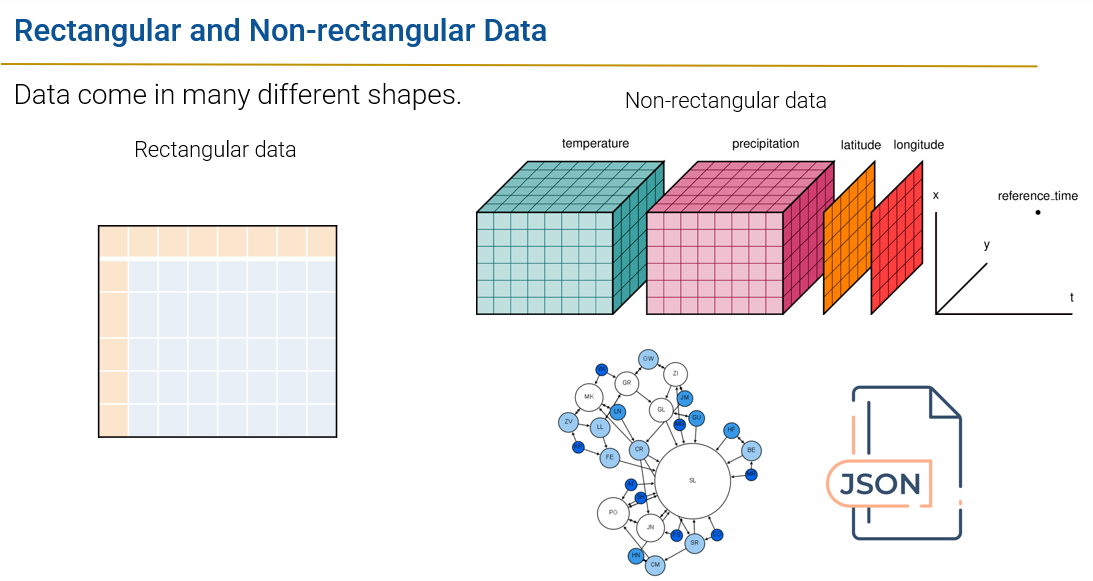


<br><br><br>

---

## Structure: Other File Formats

There are many file types for storing structured data: CSV, TSV, JSON, XML, ASCII, SAS...
* Documentation will be your best friend to understand how to process many of these file types.
* In lecture, we will cover TSV and JSON since pandas supports them out-of-box.

The `pd.read_csv` function also reads in TSVs if we specify the **delimiter** with parameter `sep='\t'` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)).

In [ ]:
tuberculosis_df_tsv = pd.read_csv("data/cdc_tuberculosis.tsv", sep='\t')
tuberculosis_df_tsv.head()

In [ ]:
with open("data/cdc_tuberculosis.tsv", "r") as f:
    for _, row in zip(range(4), f):
        print(repr(row)) # print raw strings

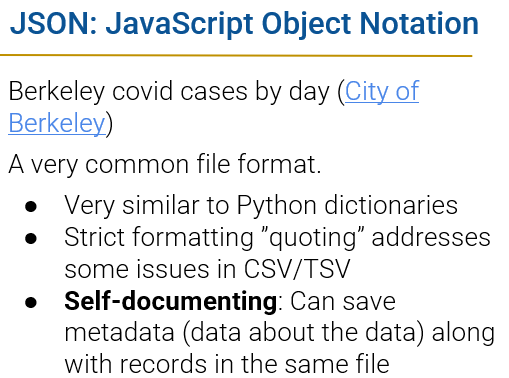

<br> <br>

---


### JSON Example
The City of Berkeley Open Data [website](https://data.cityofberkeley.info/Health/COVID-19-Confirmed-Cases/xn6j-b766) has a dataset with COVID-19 Confirmed Cases among Berkeley residents by date.

Let's first check out this website.



#### File size

- Often, I like to start my analysis by getting a rough estimate of the size of the data.  
- This will help inform the tools I use and how I view the data.  
- If it is relatively small I might use a text editor or a spreadsheet to look at the data.  
- If it is larger, I might jump to more programmatic exploration or even used distributed computing tools.

However here we will use Python tools to probe the file.

Since these seem to be text files I might also want to investigate the number of lines, which often corresponds to the number of records.

In [ ]:
import os

covid_file = 'data/confirmed-cases.json'

print(covid_file, "is", os.path.getsize(covid_file) / 1e6, "MB")

As part of your workflow, you should also learn some basic Unix commands, as these are often very handy (in fact, there's an entire book called ["Data Science at the Command Line"](https://datascienceatthecommandline.com) that explores this idea in depth!).

In Jupyter/IPython, you can prefix lines with `!` to execute arbitrary Unix commands, and within those lines, you can refer to Python variables and expressions with the syntax `{expr}`. 

Here, we use the `ls` command to list files, using the `-lh` flags, which request "long format with information in human-readable form". We also use the `wc` command for "word count", but with the `-l` flag, which asks for line counts instead of words.

These two give us the same information as the code above, albeit in a slightly different form:

In [ ]:
!ls -lh {covid_file}
!wc -l {covid_file}

#### File contents

Because we have a text file in a visual IDE like Jupyter/DataHub, I'm going to visually explore the data via the built-in file explorer.

1. To the Jupyter view!

2. To the Python view...?

In [ ]:
with open(covid_file, "r") as f:
    for i, row in enumerate(f):
        print(repr(row)) # print raw strings
        if i >= 4: break

In the same vein, we can use the `head` Unix command (which is where Pandas' `head` method comes from!) to see the first few lines of the file:

In [ ]:
...


<details>
<summary>Click to show solution</summary>

<pre>

!head -5 {covid_file}

</pre>
</details>



1. Back to the Python view.

    In order to load the JSON file into pandas, Let's first do some **EDA** with the Python `json` package to understand the particular structure of this JSON file so that we can decide what (if anything) to load into Pandas. 

### EDA: Digging into JSON

Python has relatively good support for JSON data since it closely matches the internal python object model.  In the following cell we import the entire JSON datafile into a python dictionary using the `json` package.

In [ ]:
import json

with open(covid_file, "rb") as f:
    covid_json = json.load(f)

The `covid_json` variable is now a dictionary encoding the data in the file:

In [ ]:
type(covid_json)

#### Examine what keys are in the top level json object

We can list the keys to determine what data is stored in the object.

In [ ]:
...


<details>
<summary>Click to show solution</summary>

<pre>

covid_json.keys()

</pre>
</details>


**Observation**: The JSON dictionary contains a `meta` key which likely refers to meta data (data about the data).  Meta data often maintained with the data and can be a good source of additional information.

<br/>

We can investigate the meta data further by examining the keys associated with the metadata.

In [ ]:
...


<details>
<summary>Click to show solution</summary>

<pre>

covid_json['meta'].keys()

</pre>
</details>



The `meta` key contains another dictionary called `view`.  This likely refers to meta-data about a particular "view" of some underlying database.  We will learn more about views when we study SQL later in the class.    

In [ ]:
...


<details>
<summary>Click to show solution</summary>

<pre>

covid_json['meta']['view'].keys()

</pre>
</details>


Notice that this a nested/recursive data structure.  As we dig deeper we reveal more and more keys and the corresponding data:

```
meta
|-> data
    | ... (haven't explored yet)
|-> view
    | -> id
    | -> name
    | -> attribution 
    ...
    | -> description
    ...
    | -> columns
    ...
```

There is a key called description in the view sub dictionary.  This likely contains a description of the data:

In [ ]:
...


<details>
<summary>Click to show solution</summary>

<pre>

print(covid_json['meta']['view']['description'])

</pre>
</details>



#### Examining the Data Field for Records

We can look at a few entries in the `data` field. This is what we'll load into Pandas.


In [ ]:
for i in range(3):
    print(f"{i:03} | {covid_json['data'][i]}")

Observations:
* These look like equal-length records, so maybe `data` is a table!
* But what do each of values in the record mean? Where can we find column headers?

Back to the metadata.

#### Columns Metadata

Another potentially useful key in the metadata dictionary is the `columns`.  This returns a list:

In [ ]:
covid_json['meta']['view']['columns']

Let's go back to the file explorer.

Based on the contents of this key, what are reasonable names for each column in the `data` table?

You can also get the view that Jupyter provides in the file explorer by using Python. This displays our JSON object as an interacive graphical object with a built-in search box:

In [ ]:
from IPython.display import JSON
JSON(covid_json)

#### Summary of exploring the JSON file

1. The above **metadata** tells us a lot about the columns in the data including column names, potential data anomalies, and a basic statistic. 
1. Because of its non-tabular structure, JSON makes it easier (than CSV) to create **self-documenting data**, meaning that information about the data is stored in the same file as the data.
1. Self documenting data can be helpful since it maintains its own description and these descriptions are more likely to be updated as data changes. 

### JSON with pandas

After our above EDA, let's finally go about loading the data (not the metadata) into a pandas dataframe.

In the following block of code we:
1. Translate the JSON records into a dataframe:

    * fields: `covid_json['meta']['view']['columns']`
    * records: `covid_json['data']`
    
1. Remove columns that have no metadata description.  This would be a bad idea in general but here we remove these columns since the above analysis suggests that they are unlikely to contain useful information.
1. Examine the `tail` of the table.

In [ ]:
# pd.read_json(covid_file)

In [ ]:
# Load the data from JSON and assign column titles
covid = pd.DataFrame(
    covid_json['data'],
    columns=[c['name'] for c in covid_json['meta']['view']['columns']])

covid.tail()

## Variables
- Variables Are Columns. Need to handle carefully during EDA.

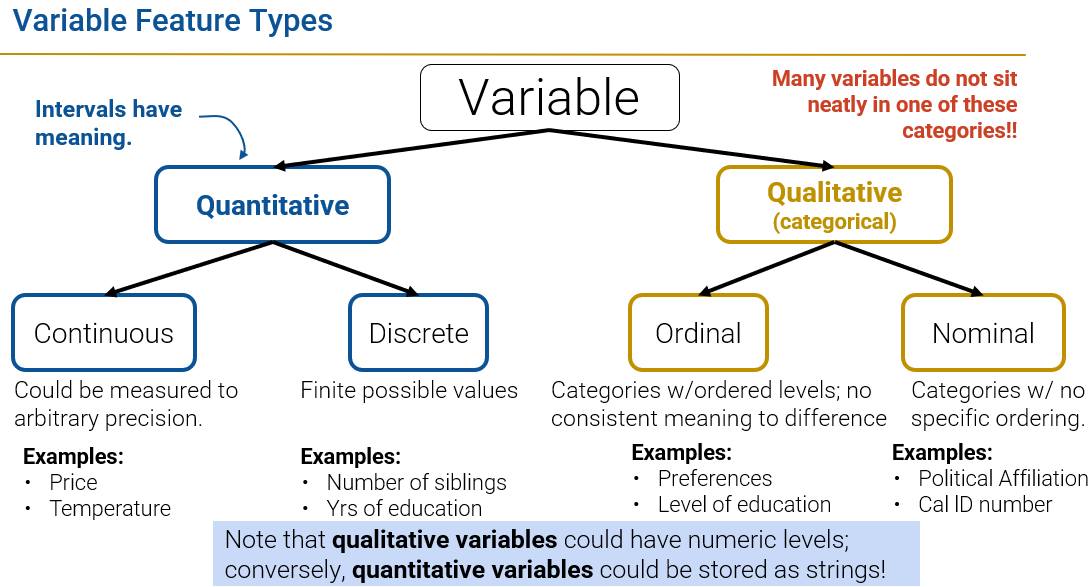

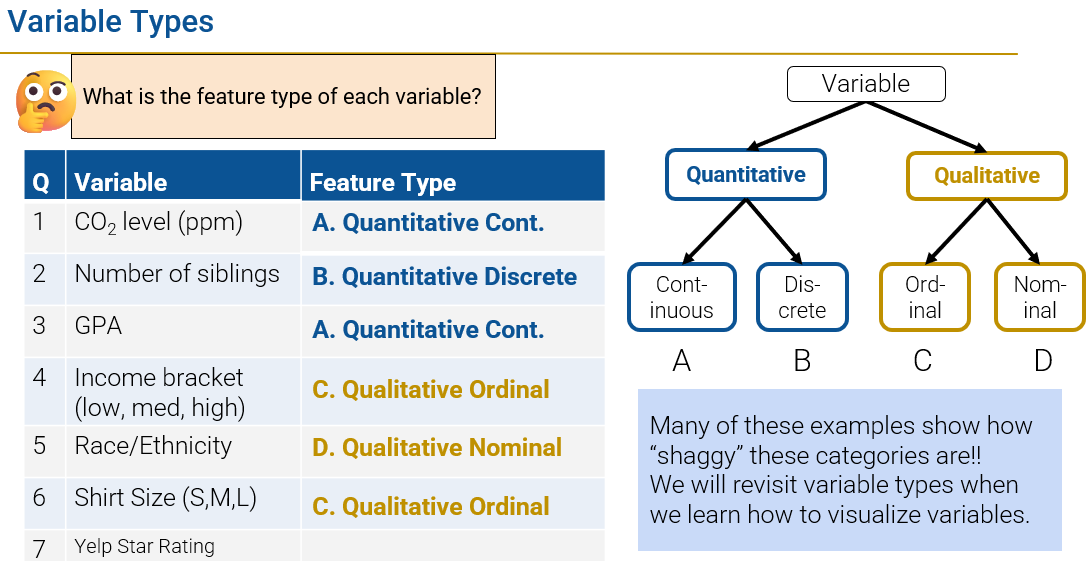

<br/>

---


## Follow lec06-07-part-3 for Scope & Temporality and other related content.
